In [20]:
# Number of people
n <- 1000

# The people will live in a square with area side^2
side <- ceiling(sqrt(n))

df <- data.frame(x=((0:(n-1)) %% side),
                 y=floor((0:(n-1)) / side), row.names=0:(n-1))

# Most lots will have a race; some will be empty, ie uninhabited
races <- c("forestgreen", "dodgerblue", "darkred")

# Assign races iid uniformly; leave roughly 10% of lots empty
df$race <- sample(c(races, "empty"), n, replace=TRUE,
                  prob=c(rep(0.90 / length(races), length(races)),
                         0.10))

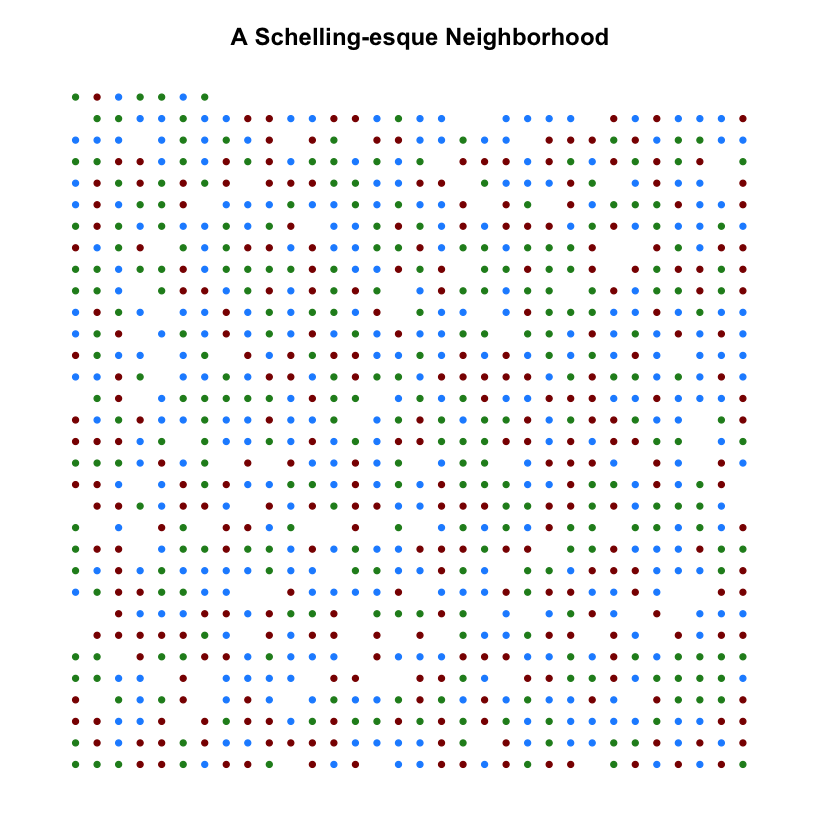

In [21]:
PlotNeighborhood <- function() {
  
  with(subset(df, race != "empty"),
       plot(x, y, col=race, pch=20, axes=FALSE,
            xlab="", ylab="", xlim=c(0, side), ylim=c(0, side),
            main="A Schelling-esque Neighborhood"))
  
}

#dev.new(height=8, width=8)
par(mar=rep(1, 4), oma=rep(1, 4))
PlotNeighborhood()
#savePlot("neighborhood_before_movement.png")


In [22]:
# Neighbors are counted within a Chebyshev distance <= depth
depth <- 3

CountNeighbors <- function(i) {
  
  # Count people of each race in person i's immediate neighborhood
  curr.x <- i %% side
  curr.y <- floor(i / side)
  neighbors <- subset(df, x %in% (curr.x - depth):(curr.x + depth) &
                        y %in% (curr.y - depth):(curr.y + depth) &
                        !(curr.x == x & curr.y == y))
  
  return(sapply(races, function(x) { sum(neighbors$race == x) }))
  
}

In [23]:
# Apply CountNeighbors to the entire data frame; append results to df
df <- cbind(df, t(sapply(0:(n - 1), CountNeighbors)))

df$num.neighbors <- rowSums(df[ , races])

# Minimum fraction of own-race neighbors
fraction <- 0.30

In [25]:
head(df)

,x,y,race,forestgreen,dodgerblue,darkred,num.neighbors
,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<dbl>
0,0,0,forestgreen,4,4,6,14
1,1,0,forestgreen,5,4,9,18
2,2,0,forestgreen,7,4,10,21
3,3,0,darkred,8,5,11,24
4,4,0,darkred,7,7,10,24
5,5,0,forestgreen,5,8,12,25


In [6]:
GetPeopleWhoWantToMove <- function(curr.race) {
  
  subset.who.want.to.move <-
    subset(df, race == curr.race &
             get(curr.race) / num.neighbors < fraction)
  
  return(rownames(subset.who.want.to.move))
  
}


In [7]:
AdjustNeighborCounts <- function(row, race.of.mover, delta) {
  
  curr.x <- as.integer(row) %% side
  curr.y <- floor(as.integer(row) / side)
  
  df[df$x %in% (curr.x - depth):(curr.x + depth) &
       df$y %in% (curr.y - depth):(curr.y + depth) &
       !(curr.x == df$x & curr.y == df$y),
     c(race.of.mover, "num.neighbors")] <<- 
    df[df$x %in% (curr.x - depth):(curr.x + depth) &
         df$y %in% (curr.y - depth):(curr.y + depth) &
         !(curr.x == df$x & curr.y == df$y),
       c(race.of.mover, "num.neighbors")] + delta
  
}

In [8]:
MoveOnePerson <- function() {
  
  # Returns 1 if a person was successfully moved, and 0 otherwise
  
  people.who.want.to.move <- c(lapply(races, GetPeopleWhoWantToMove),
                               recursive=TRUE)
  
  if (!length(people.who.want.to.move) >= 1) return(0)
  
  # Of people who want to move, pick one uniformly at random
  person.who.will.move <- sample(people.who.want.to.move, size=1)
  
  race.of.mover <- df$race[rownames(df) == person.who.will.move]
  
  possible.new.homes <- rownames(
    subset(df, race == "empty" &
             get(race.of.mover) / num.neighbors >= fraction))
  
  if (!length(possible.new.homes) >= 1) return(0)
  
  # Of acceptable new homes, choose one uniformly at random
  new.home <- sample(possible.new.homes, size=1)
  
  df[rownames(df) == new.home, ]$race <<- race.of.mover
  df[rownames(df) == person.who.will.move, ]$race <<- "empty"
  
  AdjustNeighborCounts(person.who.will.move, race.of.mover, -1)
  AdjustNeighborCounts(new.home, race.of.mover, +1)
  
  return(1)
  
}

In [9]:
RunSimulation <- function(max.movements = 5000, plots.in.loop=TRUE) {
  
  par(mar=rep(1, 4), oma=rep(1, 4))
  
  for(i in 1:max.movements) {
    
    if (!MoveOnePerson()) break
    if (plots.in.loop & (i %% 500) == 0) PlotNeighborhood()
    
  }
  
}

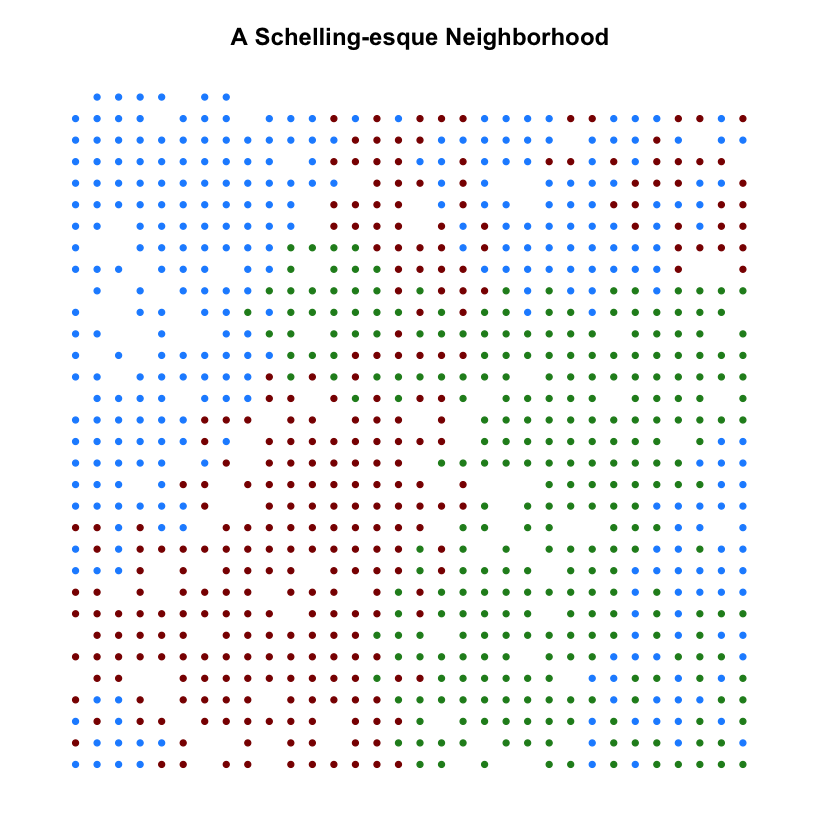

In [10]:
RunSimulation(max.movements=500)

In [22]:
library(animation)

saveVideo(RunSimulation(),
          video.name="schelling_neighborhood_model.mp4",
          interval=0.20, outdir=getwd())

dev.new(height=8, width=8)
par(mar=rep(1, 4), oma=rep(1, 4))
PlotNeighborhood()
savePlot("neighborhood_after_movement.png")



Executing: 'ffmpeg' -y -framerate 5 -i Rplot%d.png -pix_fmt yuv420p schelling_neighborhood_model.mp4


ERROR: Error in savePlot("neighborhood_after_movement.png"): can only copy from 'X11(type="*cairo")' devices
